In [ ]:
# ============================================================
# Analisis Tren Indeks Ketahanan Pangan (IKP) Provinsi Indonesia
# Tahun 2020–2024 Berdasarkan Produktivitas Jagung
#
# Metode     : Feedforward Neural Network (FNN)
# Framework  : TensorFlow / Keras
# Tujuan     : Klasifikasi Kelompok IKP
# ============================================================


In [1]:
# Instalasi library (Google Colab)
!pip install tensorflow scikit-learn matplotlib seaborn pandas numpy -q

# Import library utama
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD


In [2]:
# Load dataset jagung dan IKP
df_jagung = pd.read_csv("/content/Data_Jagung_2020_2024_Bersih.csv")
df_ikp    = pd.read_csv("/content/ikp provinsi.csv")

# Tampilkan data awal
df_jagung.head(), df_ikp.head()


(         Provinsi Luas Panen (ha) Produktivitas (ku/ha) Produksi (ton)  Tahun
 0            ACEH         11581.2                 55.22        63950.8   2020
 1  SUMATERA UTARA       135334.39                 57.87      783126.62   2020
 2  SUMATERA BARAT        65756.37                 64.64      425025.38   2020
 3            RIAU          138.92                 34.03         472.78   2020
 4           JAMBI            1111                 68.45        7604.47   2020,
    NO  KODE PROV        PROVINSI  TAHUN    IKP  PERINGKAT  Kelompok IKP
 0   1         11            ACEH   2019  66.22         23             5
 1   2         12  SUMATERA UTARA   2019  69.81         16             5
 2   3         13  SUMATERA BARAT   2019  75.43          9             6
 3   4         14            RIAU   2019  62.37         25             4
 4   5         15           JAMBI   2019  68.23         19             5)

In [3]:
# Samakan nama kolom agar bisa di-merge
df_jagung.rename(columns={
    'Provinsi': 'PROVINSI',
    'Tahun': 'TAHUN',
    'Luas Panen (ha)': 'LUAS_PANEN',
    'Produktivitas (ku/ha)': 'PRODUKTIVITAS',
    'Produksi (ton)': 'PRODUKSI'
}, inplace=True)


In [4]:
# Filter IKP tahun 2020–2024
df_ikp_filtered = df_ikp[df_ikp['TAHUN'].isin(df_jagung['TAHUN'].unique())]

# Merge berdasarkan provinsi & tahun
df = pd.merge(
    df_jagung,
    df_ikp_filtered[['PROVINSI','TAHUN','IKP','Kelompok IKP']],
    on=['PROVINSI','TAHUN'],
    how='inner'
)

df.head()


,PROVINSI,LUAS_PANEN,PRODUKTIVITAS,PRODUKSI,TAHUN,IKP,Kelompok IKP
0,ACEH,11581.2,55.22,63950.8,2020,70.92,5
1,SUMATERA UTARA,135334.39,57.87,783126.62,2020,71.84,5
2,SUMATERA BARAT,65756.37,64.64,425025.38,2020,78.64,6
3,RIAU,138.92,34.03,472.78,2020,64.12,4
4,JAMBI,1111,68.45,7604.47,2020,70.00,5


In [5]:
# Informasi dataset
df.info()
df.describe()
print("Jumlah data setelah merge:", len(df))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PROVINSI       160 non-null    object 
 1   LUAS_PANEN     160 non-null    object 
 2   PRODUKTIVITAS  160 non-null    object 
 3   PRODUKSI       160 non-null    object 
 4   TAHUN          160 non-null    int64  
 5   IKP            160 non-null    float64
 6   Kelompok IKP   160 non-null    int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 8.9+ KB
Jumlah data setelah merge: 160


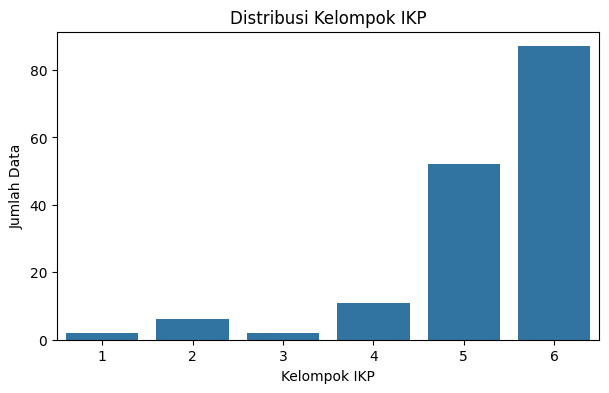

In [6]:
plt.figure(figsize=(7,4))
sns.countplot(x='Kelompok IKP', data=df)
plt.title('Distribusi Kelompok IKP')
plt.xlabel('Kelompok IKP')
plt.ylabel('Jumlah Data')
plt.show()


In [8]:
# Pilih fitur dan target
feature_cols = ['LUAS_PANEN', 'PRODUKTIVITAS', 'PRODUKSI']
target_col   = 'Kelompok IKP'

# Bersihkan data tidak valid
df_clean = df.replace('-', np.nan).dropna(subset=feature_cols + [target_col])
df_clean[feature_cols] = df_clean[feature_cols].astype(float)

X = df_clean[feature_cols].values
y = df_clean[target_col].values.astype(int)

# Encoding label (1–6 → 0–5)
y_encoded = y - 1
num_classes = len(np.unique(y_encoded))
y_cat = tf.keras.utils.to_categorical(y_encoded, num_classes)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]


In [10]:
def build_model(optimizer='adam', activation='relu', learning_rate=0.001):
    # Optimizer adaptif (Adam) atau Gradient Descent (SGD)
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = SGD(learning_rate=learning_rate)

    model = Sequential([
        Dense(64, activation=activation, input_shape=(input_dim,)),
        Dropout(0.2),  # Mencegah overfitting
        Dense(32, activation=activation),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=opt,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [11]:
base_model = build_model('adam', 'relu', 0.001)

history_base = base_model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=16,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - accuracy: 0.1080 - loss: 1.8707 - val_accuracy: 0.0800 - val_loss: 1.8416
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2097 - loss: 1.7950 - val_accuracy: 0.1200 - val_loss: 1.7438
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2765 - loss: 1.6992 - val_accuracy: 0.2400 - val_loss: 1.6647
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4000 - loss: 1.6731 - val_accuracy: 0.5600 - val_loss: 1.5920
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.5824 - loss: 1.6101 - val_accuracy: 0.6400 - val_loss: 1.5127
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4767 - loss: 1.5468 - val_accuracy: 0.6400 - val_loss: 1.4350
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5484 - loss: 1.4648 - val_accuracy: 0.6400 - val_loss: 1.3573
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6063 - loss: 1.4321 - val_accuracy: 0.6400 - val_loss: 1.2843

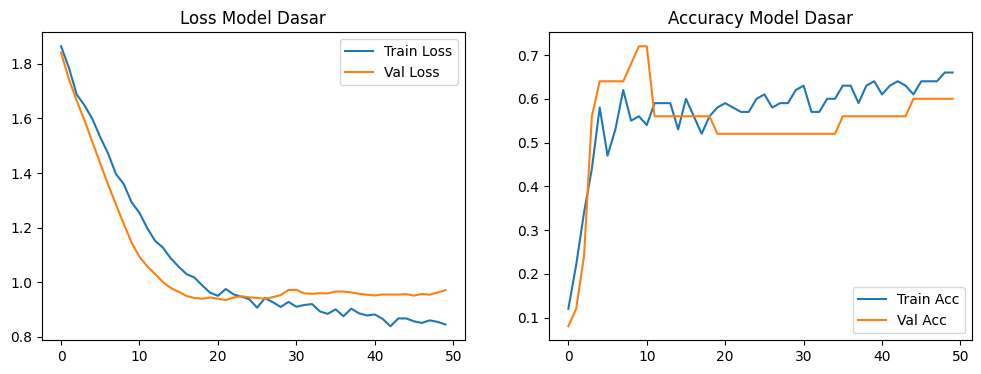

In [12]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history_base.history['loss'], label='Train Loss')
plt.plot(history_base.history['val_loss'], label='Val Loss')
plt.title('Loss Model Dasar')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_base.history['accuracy'], label='Train Acc')
plt.plot(history_base.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Model Dasar')
plt.legend()

plt.show()


In [13]:
model_adam = build_model('adam','relu',0.001)
model_sgd  = build_model('sgd','relu',0.01)

hist_adam = model_adam.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=16, verbose=0)
hist_sgd  = model_sgd.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=16, verbose=0)


In [14]:
model_relu = build_model('adam','relu',0.001)
model_tanh = build_model('adam','tanh',0.001)

hist_relu = model_relu.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=16, verbose=0)
hist_tanh = model_tanh.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=16, verbose=0)


In [15]:
model_lr_small = build_model('adam','relu',0.0005)
model_lr_big   = build_model('adam','relu',0.01)

hist_lr_small = model_lr_small.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=16, verbose=0)
hist_lr_big   = model_lr_big.fit(X_train_scaled, y_train, validation_split=0.2, epochs=50, batch_size=16, verbose=0)


In [16]:
experiments = {
    'Adam': hist_adam,
    'SGD': hist_sgd,
    'ReLU': hist_relu,
    'Tanh': hist_tanh,
    'LR kecil': hist_lr_small,
    'LR besar': hist_lr_big
}

rows = []
for name, hist in experiments.items():
    rows.append({
        'Eksperimen': name,
        'Best Val Accuracy': max(hist.history['val_accuracy']),
        'Best Val Loss': min(hist.history['val_loss'])
    })

df_exp = pd.DataFrame(rows)
df_exp


,Eksperimen,Best Val Accuracy,Best Val Loss
0,Adam,0.60,0.944140
1,SGD,0.76,0.917325
2,ReLU,0.60,0.921956
3,Tanh,0.68,0.940330
4,LR kecil,0.72,0.948368
5,LR besar,0.72,0.922536


In [17]:
best_model = model_adam  # berdasarkan hasil eksperimen

test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test Accuracy:", test_acc)

y_pred = np.argmax(best_model.predict(X_test_scaled), axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred))


Test Accuracy: 0.59375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         2
           4       0.55      0.55      0.55        11
           5       0.62      0.76      0.68        17

    accuracy                           0.59        32
   macro avg       0.23      0.26      0.25        32
weighted avg       0.52      0.59      0.55        32



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


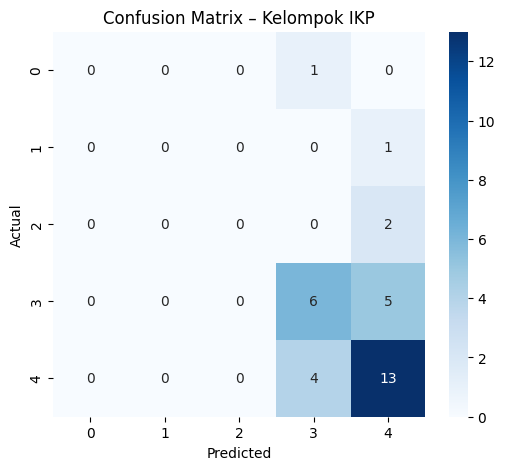

In [18]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix – Kelompok IKP')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
